Implementation of two custering algorithms:
- K-means - implementation in kmean.py
- DBSCAN - implementations in dbscan_optimized.py 

Algorithms are shown on Emnist - Mnist dataset

https://www.geeksforgeeks.org/k-means-clustering-introduction/ - kmeans

https://www.geeksforgeeks.org/dbscan-clustering-in-ml-density-based-clustering/ - dbscan

In [1]:
import numpy as np
import idx2numpy

In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
from collections import Counter
import os
import colorsys

In [4]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.decomposition import PCA

In [5]:
from helpers import get_labels, make_confusion_matrix, batch_simulation_dbscan 
from kmeans import KMeans
from dbscan_optimized import DBSCAN

In [6]:
decompressed_path = '../data'
train_images = idx2numpy.convert_from_file(f'{decompressed_path}/emnist-mnist-train-images-idx3-ubyte')
train_labels = idx2numpy.convert_from_file(f'{decompressed_path}/emnist-mnist-train-labels-idx1-ubyte')
test_images = idx2numpy.convert_from_file(f'{decompressed_path}/emnist-mnist-test-images-idx3-ubyte')
test_labels = idx2numpy.convert_from_file(f'{decompressed_path}/emnist-mnist-test-labels-idx1-ubyte')

In [7]:
print(f"train images: {len(train_images)}")
print(f"train labels: {len(train_labels)}")
print(f"test images: {len(test_images)}")
print(f"test labels: {len(test_labels)}")

train images: 60000
train labels: 60000
test images: 10000
test labels: 10000


In [8]:
print("Shapes:")
print(f"train_images: {train_images.shape}")
print(f"train_labels: {train_labels.shape}")
print(f"test_images: {test_images.shape}")
print(f"test_labels: {test_labels.shape}")

Shapes:
train_images: (60000, 28, 28)
train_labels: (60000,)
test_images: (10000, 28, 28)
test_labels: (10000,)


In [9]:
train_data = train_images.reshape(-1, 784)
test_data = test_images.reshape(-1, 784)

Scale into dimensions

In [10]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [11]:
print("Shapes:")
print(f"train_images: {train_images.shape}")
print(f"train_labels: {train_labels.shape}")
print(f"test_images: {test_images.shape}")
print(f"test_labels: {test_labels.shape}")

Shapes:
train_images: (60000, 28, 28)
train_labels: (60000,)
test_images: (10000, 28, 28)
test_labels: (10000,)


Visualize elements from the MNIST dataset

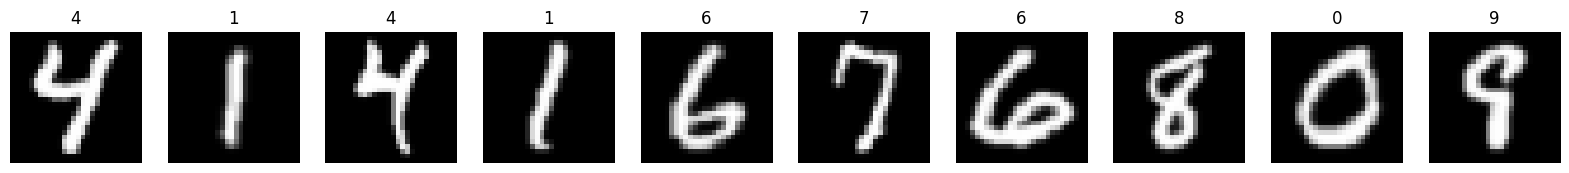

In [12]:
n_digits = 10
fig, axes = plt.subplots(nrows=1, ncols=n_digits, figsize=(n_digits*2, n_digits))

for i in range(n_digits):
    rotated_img = np.rot90(train_images[i], k=1)          # rotate 90° CCW
    flipped_img = np.flipud(rotated_img)                   # flip upside down
    axes[i].imshow(flipped_img, cmap='gray')
    axes[i].set_title(f'{train_labels[i]}')
    axes[i].axis('off')

Display label per type data:

In [13]:
Counter(train_labels)

Counter({np.uint8(4): 6000,
         np.uint8(1): 6000,
         np.uint8(6): 6000,
         np.uint8(7): 6000,
         np.uint8(8): 6000,
         np.uint8(0): 6000,
         np.uint8(9): 6000,
         np.uint8(5): 6000,
         np.uint8(3): 6000,
         np.uint8(2): 6000})

Dataset is balanced

## K-means algorithm

In [14]:
n_clusters = 20
n_iter=5

In [15]:
my_kmeans = KMeans(n_clusters=n_clusters,n_init=n_iter, verbose=1).fit(train_data)

fitting...
Iteration number: 0/5 of different centroids
Initializing centroids...
initializing centroid: 1...
initializing centroid: 2...
initializing centroid: 3...
initializing centroid: 4...
initializing centroid: 5...
initializing centroid: 6...
initializing centroid: 7...
initializing centroid: 8...
initializing centroid: 9...
initializing centroid: 10...
initializing centroid: 11...
initializing centroid: 12...
initializing centroid: 13...
initializing centroid: 14...
initializing centroid: 15...
initializing centroid: 16...
initializing centroid: 17...
initializing centroid: 18...
initializing centroid: 19...
Iteration number: 1/5 of different centroids
Initializing centroids...
initializing centroid: 1...
initializing centroid: 2...
initializing centroid: 3...
initializing centroid: 4...
initializing centroid: 5...
initializing centroid: 6...
initializing centroid: 7...
initializing centroid: 8...
initializing centroid: 9...
initializing centroid: 10...
initializing centroid: 1

Check the inertia

In [16]:
print(my_kmeans.inertia)

2450933.17778572


Run Predictions:

ValueError: too many values to unpack (expected 2)

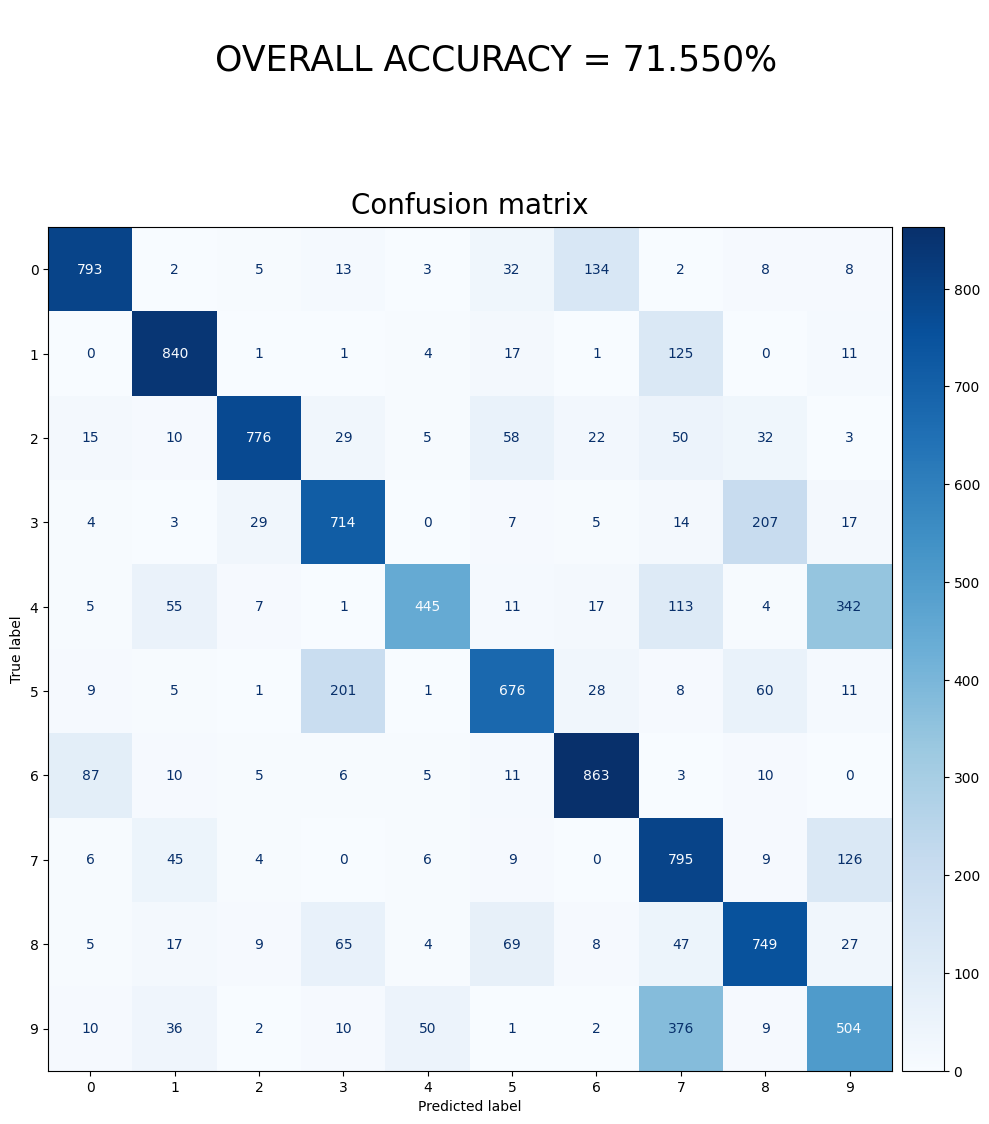

In [ ]:
mapping = get_labels(my_kmeans.labels, train_labels)
test_clusters = my_kmeans.predict(test_data)
y_pred = np.array([mapping[c] for c in test_clusters])
y_true = test_labels
fig, _, ax = make_confusion_matrix(y_true, y_pred)

Plot the centroids

In [ ]:
centroids = my_kmeans.centroids

In [ ]:
fig, axes = plt.subplots(1, n_clusters, figsize=(30,10))
for c in range(n_clusters):
    centroid_img = centroids[c].reshape(28, 28)
    rotated_img = np.rot90(centroid_img, k=1)   # rotate 90° CCW
    flipped_img = np.flipud(rotated_img)        # flip vertically
    axes[c].imshow(flipped_img, cmap='gray')
    axes[c].set_title(f"C:{c} | N:{mapping[c]}")
    axes[c].axis('off')
plt.show()

## DBSCAN

Observation:
- When ran on raw Mnist:
    - It either creates a lot of small clusters (close to number of samples)
    - Or collapses everything into few giant clusters classifying everything as a single number or two
    - Or just marks everything as noise (when radius is too low)

In [ ]:
radius_list = [0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]
neighbors_list = [2,3,4,5,6,7]
save_folder_path = './images'

In [ ]:
os.mkdir(save_folder_path) if not os.path.exists(save_folder_path) else None
lengths = batch_simulation_dbscan(radius_list=radius_list,
                                  neighbors_list=neighbors_list,
                                  data=train_data,
                                  labels=train_labels,
                                  folder_path=save_folder_path,
                                  appendix="_raw_data",
                                  verbose=3)

### PCA

Observation:
- Using PCA pre-processing improves DBSCAN accuracy
- PCA offers reasonable time to preprocess data, however we will later us t-SNE that gives astounding results but takes a lot of time.

n_components = How any dimensions you wanna keep

In [ ]:
n_components = 15
pca = PCA(n_components).fit(train_data)

In [ ]:
X_pca = pca.transform(train_data)

In [ ]:
os.mkdir(save_folder_path) if not os.path.exists(save_folder_path) else None
lengths_pca = batch_simulation_dbscan(radius_list=radius_list,
                                      neighbors_list=neighbors_list,
                                      data=X_pca,
                                      labels=train_labels,
                                      folder_path=save_folder_path,
                                      appendix=f"_pca_{n_components}_dim")

### TSNE

Observation:
- Using t-SNE greatly improves DBSCAN accuracy
- reducing the number of dimensions to just 2 makes it able to reach over 97% of correct predictions

n_components = How any dimensions you wanna keep

In [ ]:
n_components = 3
tsne = TSNE(n_components, random_state=42, verbose=3)

In [ ]:
X_tsne = tsne.fit_transform(train_data)

In [ ]:
os.mkdir(save_folder_path) if not os.path.exists(save_folder_path) else None
lengths_tsne = batch_simulation_dbscan(radius_list=radius_list,
                                      neighbors_list=neighbors_list,
                                      data=X_tsne,
                                      labels=train_labels,
                                      folder_path=save_folder_path,
                                      appendix=f"_tsne_{n_components}_dim")

### TSNE visualization of the entire MNIST dataset
(How does passing MNIST through tSNE changes data shape)

n_components = How many dimensions you wanna keep

In [ ]:
n_components = 2   # 2D t-SNE for visualization (2 dimensions)

In [ ]:
tsne = TSNE(n_components=n_components, random_state=42, verbose=3)

In [ ]:
X_reduced = tsne.fit_transform(train_data)

In [ ]:
X_reduced.shape

In [ ]:
def get_n_colors(n):
    colors = []
    for i in range(n):
        hue = i / n  # evenly spaced hues between 0 and 1
        lightness = 0.5
        saturation = 0.9
        rgb = colorsys.hls_to_rgb(hue, lightness, saturation)
        # Convert RGB [0,1] to hex string
        colors.append('#{:02x}{:02x}{:02x}'.format(
            int(rgb[0]*255), int(rgb[1]*255), int(rgb[2]*255)
        ))
    return colors

colors = get_n_colors(10)

Here we can clearly see why did DBSCAN work so well when we pre-processed MNIST into just 2 dimensions:

In [ ]:
plt.figure(figsize=(10,10))
for digit in range(10):
    idx = train_labels == digit
    plt.scatter(X_reduced[idx,0], X_reduced[idx,1], color=colors[digit], label=str(digit), alpha=0.7)
plt.legend(title="Digit Label")
plt.show()